<a href="https://colab.research.google.com/github/t-perniola/Denoising-Autoencoders-for-GRBs-detection/blob/main/Denoising_Autoencoder_for_GRBs_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving noise management in Autoencoders for Gamma Ray Burst (GRBs) detection

This project would focus on accounting for uncertainty and noise in autoencoders used for
Gamma Ray Burst (GRB) detection. The detection problem is framed as an anomaly
detection task over time series, which can be tackled by training an Autoencoder model on
background data (i.e. signals containing no GRB) and then using the reconstruction error as
a measure of the chance that a new sequence contains a notable event (such as a GRB).
Well performing models have already been trained, but they are suboptimal in how they
account for output noise, and they do not account explicitly for input noise. The goal is to
devise methods (e.g. neuro-probabilistic models) to account for uncertainty, so as to obtain
more reliable results.

## **Importing** useful libraries

In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Colab Notebooks/AI4Ind')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import tensorflow as tf
from scipy.stats import skewnorm
from utils import *

## Let's **generate** our **syntethic** data

### Ensuring reproducibility
**Todo**: to also ensure robustness, we should iterate the process below over different seeds

In [3]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### **Training** data

We assume our data follows a **Skew-Normal** distribution, which is a simplification given that our data consists of multiple overlapping signals. Specifically, the original **background** signal is the sum of various components, including noise, external sources, etc. For now, we will use this as a **baseline**.

In [4]:
alpha_fit = 1.52731191e+00
mu_fit = 6.17068919e+01
sigma_fit = 1.70926014e+01

def generate_skewnorm_data(alpha, mu, sigma, num_samples): # size: num of distribution to output
  data = skewnorm.rvs(alpha_fit, loc=mu_fit, scale=sigma_fit, size=num_samples, random_state=42)
  return data

num_samples = 100000
training_data_original = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples)

### Skew-Normal Distribution

The **Skew-Normal distribution** is an extension of the normal distribution that includes a skewness parameter \\(\alpha\\), allowing it to model asymmetric data. It is defined as:

$$
\
f(x \mid \xi, \omega, \alpha) = \frac{2}{\omega} \phi\left( \frac{x - \xi}{\omega} \right) \Phi\left( \alpha \frac{x - \xi}{\omega} \right)
\
$$

where:

- \\(\xi\\) (*mu*): Location parameter.
- \\(\omega\\) (*sigma*): Scale parameter.
- \\(\alpha\\): Shape (skewness) parameter.
- \\(\phi(\cdot)\\): Standard normal probability density function (PDF).
- \\(\Phi(\cdot)\\): Cumulative distribution function (CDF) of the standard normal distribution.

When \\(\alpha = 0\\), the Skew-Normal distribution reduces to a standard normal distribution.


### **Reshaping** data

First, we need to **reshape** our data into smaller time-series, which will allow for a more structured analysis.
Specifically, we will create **lightcurves**, a common term for such time-series.

In this way our data will consist of $\textit{num_chunks}$ lightcurves (as rows), with each containing $\textit{chunks_size}$ bins (as columns). Each bin represents the count of gamma photons detected within a fixed time interval, which in our case is 50 ms.

In [5]:
# Reshaping data
def reshape_data(data, chunk_size):
  num_chunks = len(data) // chunk_size
  reshaped_data = data[:num_chunks * chunk_size].reshape((num_chunks, chunk_size))
  return reshaped_data, num_chunks

# Reshape training data
chunk_size = 100
training_data, num_chunks = reshape_data(training_data_original, chunk_size)
print(f"Shape of chunked data: {training_data.shape}")

Shape of chunked data: (1000, 100)


### **Validation** & **Dev-Test** set generation

We generate our validation and dev-test set by perturbing the background data: we will simply add to them some bursts that follow an **exponential decay** distribution.

We will add those bursts starting from *bin* *n.10* and they will last *20* *bins*.

*How many anomalies?*
* Respectively, the *8%* and the *5%* of our validation and dev-test
lightcurves will be anomalous.

In [6]:
## Select the percentage of anomalies
val_anomaly_perc = 0.08
test_anomaly_perc = 0.05

#### Exponential Decay

> "A quantity is subject to exponential decay if it decreases at a rate proportional to its current value. Symbolically, this process can be expressed by the following differential equation, where $N$ is the quantity and $\lambda$ (lambda) is a positive rate called the exponential decay constant:  
>
> $$\frac{dN}{dt} = -\lambda N(t)$$
>
> The solution to this equation is:  
>
> $$N(t) = N_0 e^{-\lambda t}$$
>
> where $N(t)$ is the quantity at time $t$, $N_0 = N(0)$ is the initial quantity, that is, the quantity at time $t = 0$."
>
> — [Wikipedia](https://en.wikipedia.org/wiki/Exponential_decay)


#### **Perturbing** data
We follow the pipeline below:

1.   Generating validation and dev-test set, according to the Skew-Normal distribution
2.   Chunking data
3.   Perturbing them with exponential-decay bursts

In [7]:
# 1) Generate skew-normal datapoints
val_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples = num_samples // 3)
test_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples = num_samples // 3)

# 2) Chunk data
val_data, _ = reshape_data(val_data, chunk_size)
test_data, _ = reshape_data(test_data, chunk_size)

# 3) Perturbate them with exp-decay bursts
peak_time = 10
burst_duration = 20

num_chunks_eval = val_data.shape[0]
print(f"Shape of validation and test data: {val_data.shape}")

Shape of validation and test data: (333, 100)


**3.1)** For explanatory purposes, we firstly choose a single lightcurve and we plot both the signals

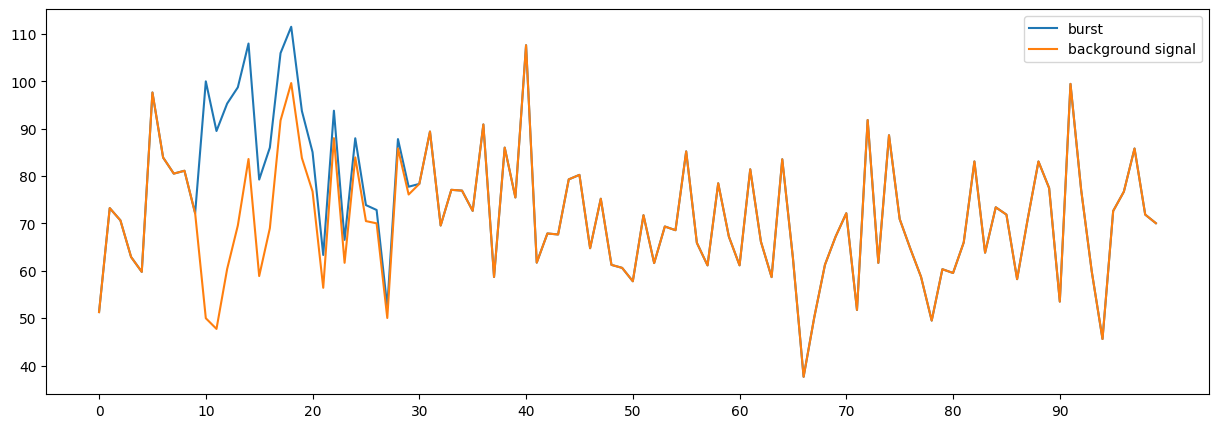

In [8]:
# 3.1) Plot both signals
i = np.random.randint(num_chunks_eval)

## add burst to bg signal
perturbed_data = val_data.copy()
amplitude = 50
lambd =  np.random.uniform(0.1, 0.2)
burst = amplitude * np.exp(-lambd * np.arange(burst_duration))
perturbed_data[i, peak_time:burst_duration + peak_time] += burst

## plot the original bg signal and the burst

plt.figure(figsize=(15, 5))
plt.plot(perturbed_data[i], label = "burst")
plt.plot(val_data[i], label = "background signal")
plt.xticks(np.arange(0, len(perturbed_data[i]), step=10))  # Ticks every 10 bins
plt.legend()
plt.show()

**3.2)** Now we apply the perturbation to all the selected validation and test light curves.

In [9]:
# Apply bursts
def add_burst(data, anomaly_indices, anomaly_percentage, amplitudes, peak_time, burst_duration):
  ## Parameters
  amplitude_lb = amplitudes["lb"]
  amplitude_ub = amplitudes["ub"]
  lambda_lb = 0.1
  lambda_ub = 0.2

  ## Apply anomalies only to a selected percentage of light curves
  perturbed_data = data.copy()
  for i in anomaly_indices:
      amplitude = np.random.randint(amplitude_lb, amplitude_ub)
      lambd = np.random.uniform(lambda_lb, lambda_ub)
      burst = amplitude * np.exp(-lambd * np.arange(burst_duration))
      perturbed_data[i, peak_time:burst_duration + peak_time] += burst  # Add the anomaly

  return perturbed_data, anomaly_indices

# Apply bursts to val and test sets
amplitudes = {"lb": 40, "ub": 60}
fixed_anomalies_idx = np.random.choice(
    num_chunks_eval, size=int(test_anomaly_perc * num_chunks_eval),
    replace=False
    )

val_data_perturbed, val_anomaly_indices = add_burst(
    val_data, fixed_anomalies_idx, val_anomaly_perc, amplitudes=amplitudes,
    peak_time=peak_time, burst_duration=burst_duration
    )
test_data_perturbed, test_anomaly_indices = add_burst (
    test_data, fixed_anomalies_idx, test_anomaly_perc, amplitudes=amplitudes,
    peak_time=peak_time, burst_duration=burst_duration
    )

## **Data analysis**

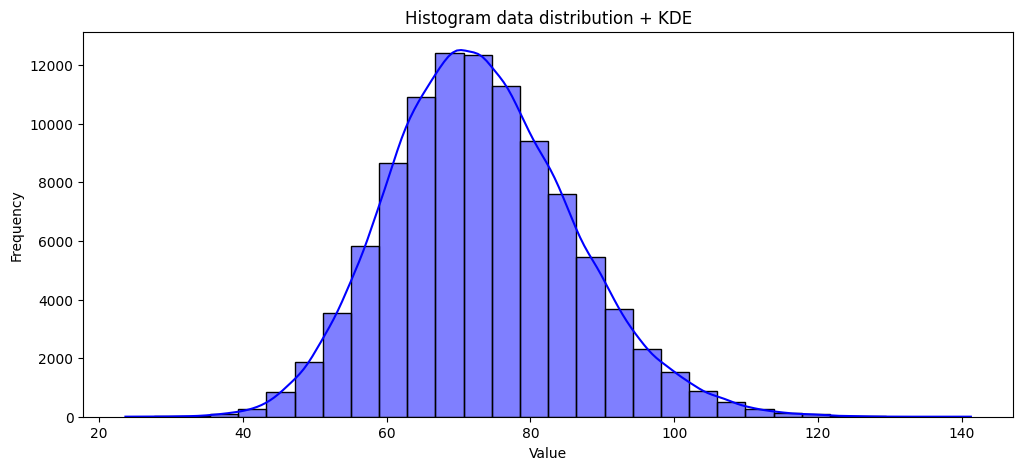

In [10]:
#@title Histogram plot to check the data distribution, that is a Skew-Normal
plt.figure(figsize=(12, 5))
sns.histplot(training_data_original, bins=30, kde=True, color="blue", alpha=0.5)
plt.title("Histogram data distribution + KDE")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

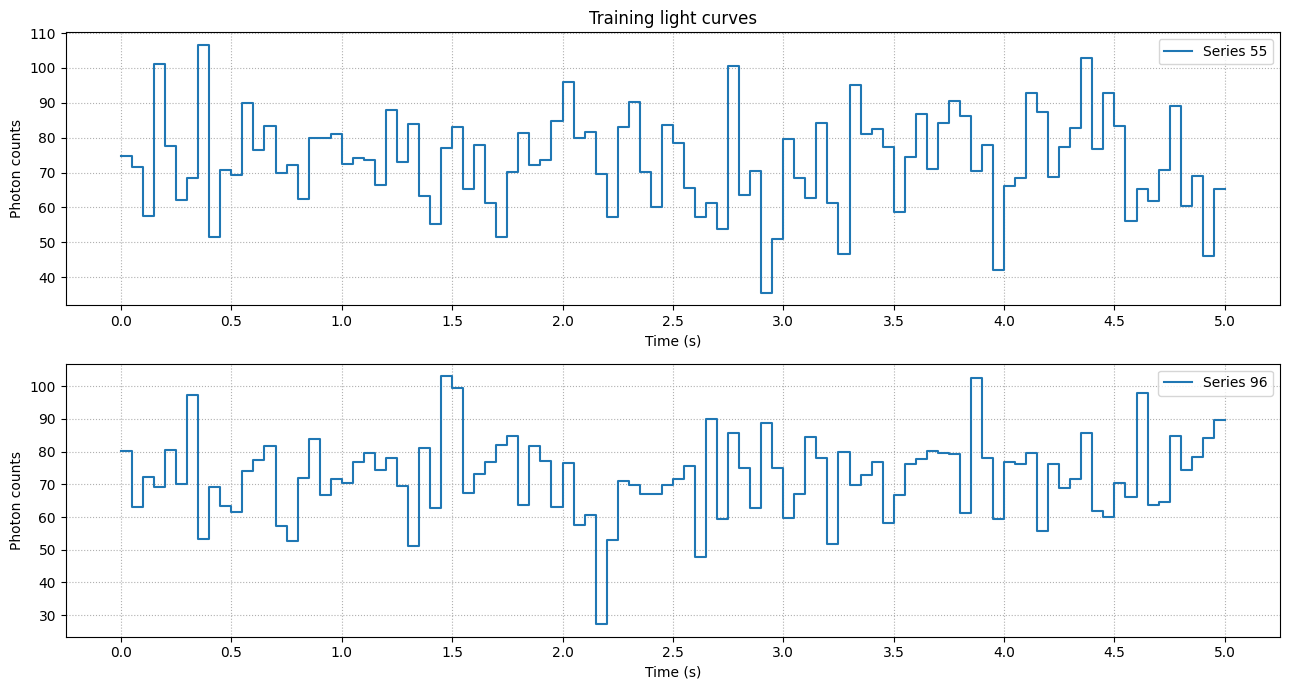

In [11]:
#@title Show training light curves, the background signals
show_box_lightcurves(training_data, num_samples=num_chunks, size=chunk_size, label="Training", bin_duration = 0.05) # 50 ms

In the plot above, we show a training lightcurve where the x-axis accounts for the **bin duration**, that is of 50 milliseconds, as anticipated before. In this way, we are specifying the **width** of each time bin.
Moreover, as said before, each of these light curves represents a background signal, therefore we can expect a "regular" behavior.

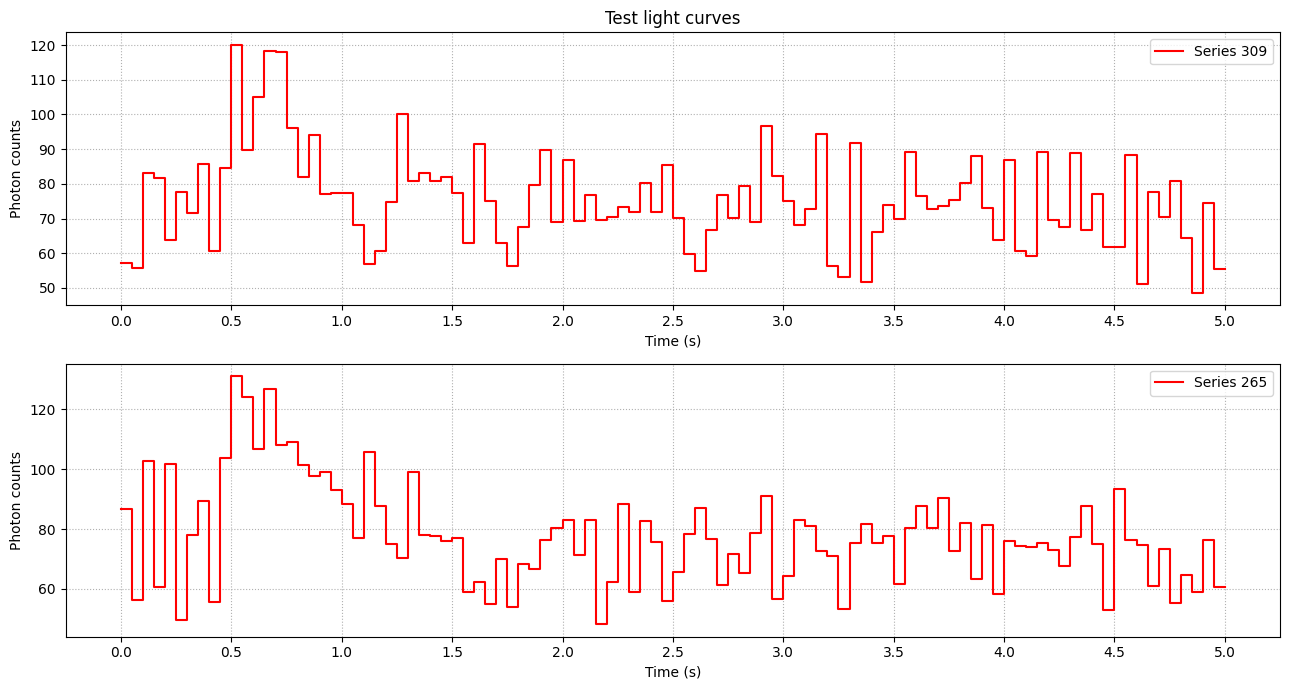

In [12]:
#@title Showing perturbed test lightcurves
show_box_lightcurves(test_data_perturbed, num_chunks, test_anomaly_indices, "Test", color = "red")

In [13]:
print(f"Real anomalies in dev-test light curves: {np.sort(test_anomaly_indices).tolist()}")

Real anomalies in dev-test light curves: [9, 25, 57, 73, 75, 126, 132, 180, 195, 197, 211, 265, 281, 296, 309, 320]


As we can quite easily observe, both the validation and test light curves are slightly more pronounced around bin n.10 (here the one starting at *time(s)=0.5*, after the conversion) which presents a **peak** and a slight decay for a period of 20 bins.

## **Autoencoding**

We will train an autoencoder that will learn to reconstruct the original background signal. In this way, in the validation and test process, we will be able to detect potential anomalies if the reconstruction error is considerably higher than a certain threshold.

In particular, we will adopt a probabilistic approach instead: we will train for **MLE** for the current observations and we will learn the best parameters that maximize the likelihood of observing our input data. In particular, we will check if the predicted distribution, composed of mean, scale and skewness, aligns with the one of the test sample: the likelihood of observing the current sample given the predicted params and the learned distribution.

In [14]:
import keras
import tensorflow_probability as tfp
from scipy.optimize import root_scalar
from keras import layers, callbacks
from tensorflow.keras.utils import plot_model

In [15]:
#@title Normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_data = scaler.fit_transform(training_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)
val_data_perturbed = scaler.transform(val_data_perturbed)
test_data_perturbed = scaler.transform(test_data_perturbed)

### Custom Loss definition
We'll use a **Negative-Log-Likelihood** (NLL) for the Skew-Normal distribution. The model is learning to predict the best Skew-Normal distribution for each light curve. Namely, the AE learns to generate a probability distribution that represents the data, outputting its mean, variance and alpha value.

Basically, this loss function evaluates how likely each individual data point (from the input series) is under the predicted Skew-Normal distribution.

In [16]:
tfd = tfp.distributions

# Custom class definition
class SkewNormal(tfp.distributions.Distribution):
    def __init__(self, loc, scale, skewness, validate_args=False, allow_nan_stats=True, name="SkewNormal"):
        parameters = dict(locals())
        self.loc = tf.convert_to_tensor(loc, dtype=tf.float32)
        self.scale = tf.convert_to_tensor(scale, dtype=tf.float32)
        self.skewness = tf.convert_to_tensor(skewness, dtype=tf.float32)
        self.normal = tfd.Normal(loc=0.0, scale=1.0)  # Standard normal

        super(SkewNormal, self).__init__(
            dtype=tf.float32,
            reparameterization_type=tfd.NOT_REPARAMETERIZED,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            parameters=parameters,
            name=name.replace(" ", "_"),
        )

    # Log-probability density function (PDF) of the Skew-Normal distribution.
    def _log_prob(self, value):
        z = (value - self.loc) / self.scale
        normal_log_prob = self.normal.log_prob(z)
        skew_factor = 2 * self.normal.cdf(self.skewness * z)

        # Ensure numerical stability
        skew_factor = tf.clip_by_value(skew_factor, 1e-6, 1.0)  # Avoid log(0)
        return normal_log_prob + tf.math.log(skew_factor) - tf.math.log(self.scale)

In [17]:
# Negative Log-Likelihood for the Skew-Normal distribution.
def skew_normal_nll(y_true, params):
  mu, sigma, alpha = params[:, 0], params[:, 1], params[:, 2]

  # reshape to (batch_size, 1)
  mu = tf.expand_dims(mu, axis=-1)
  sigma = tf.expand_dims(sigma, axis=-1)
  alpha = tf.expand_dims(alpha, axis=-1)

  sn = SkewNormal(loc=mu, scale=sigma, skewness=alpha)
  return -tf.reduce_mean(sn.log_prob(y_true))

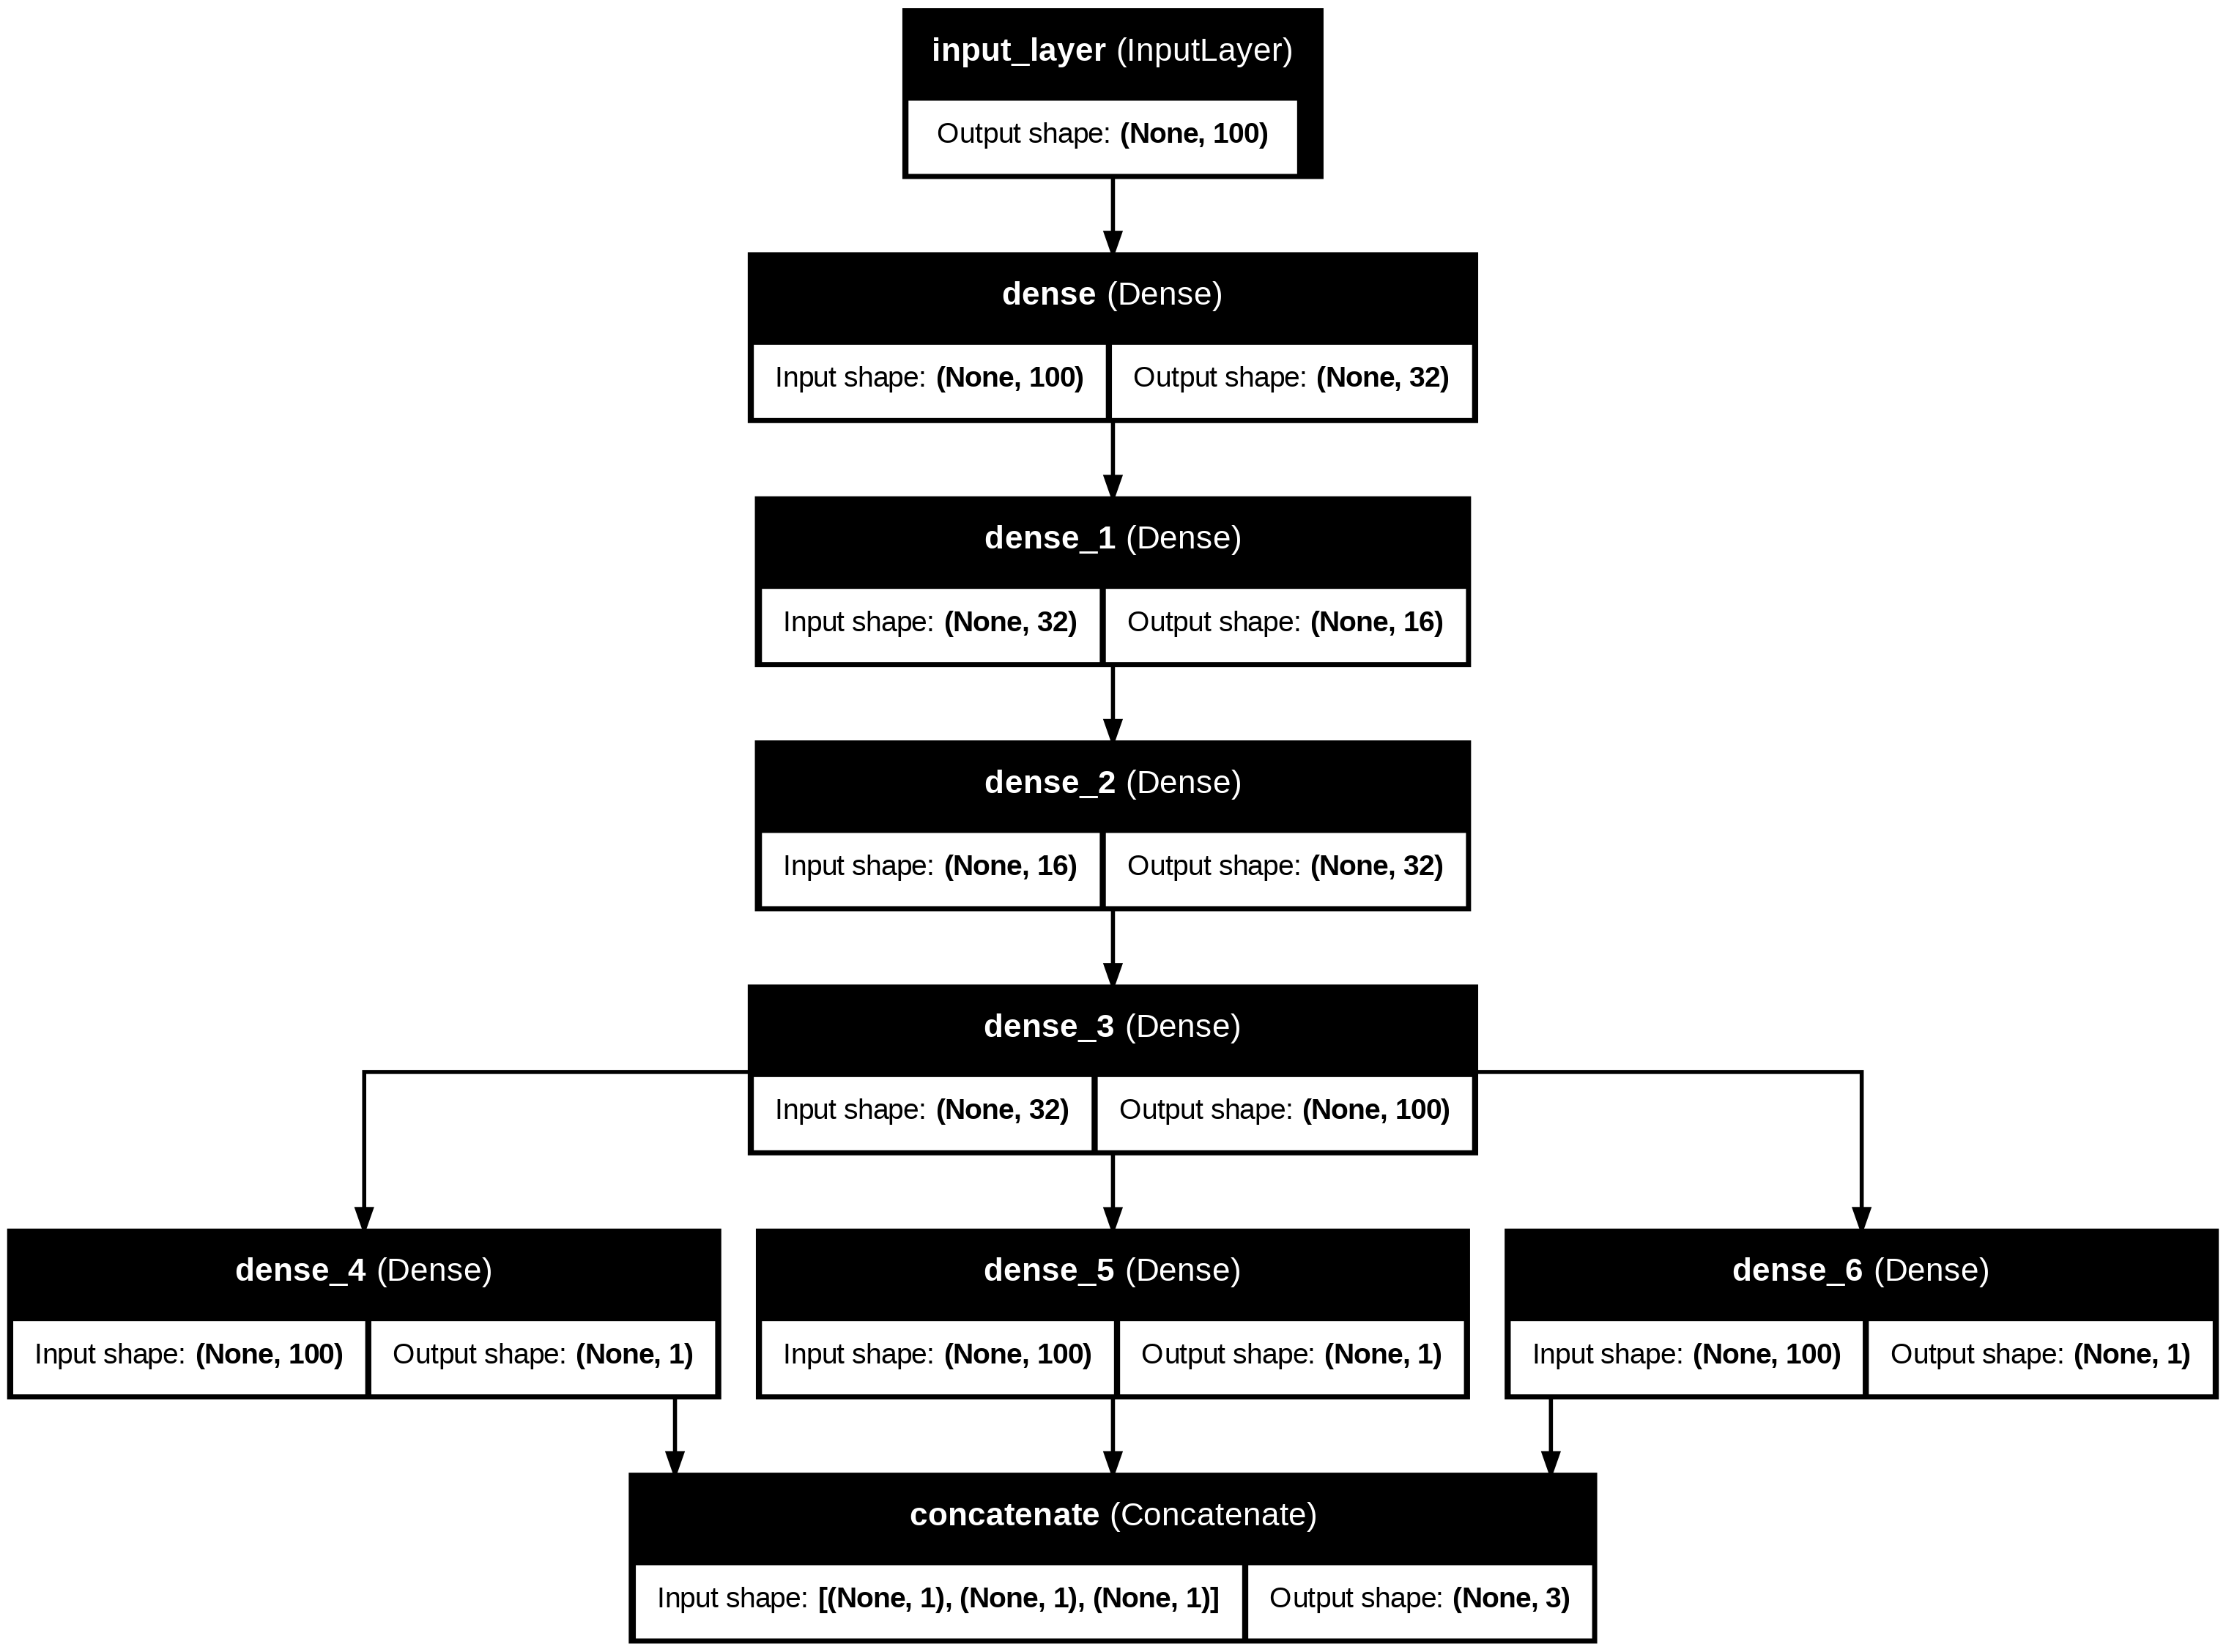

In [18]:
#@title Building the autoencoder
def build_autoencoder(input_shape, units=32):
  input_shape = (chunk_size, )
  input = keras.Input(shape = input_shape, dtype = "float32")

  # Encoder
  latent = layers.Dense(units, activation = "relu")(input)
  latent = layers.Dense(units // 2, activation = "relu")(latent)

  # Decoder
  decoder = layers.Dense(units, activation = "relu")(latent)
  decoder = layers.Dense(chunk_size, activation = "relu")(decoder)

  # Predict distribution parameters
  mu = layers.Dense(1, activation = "linear")(decoder)
  sigma = layers.Dense(1, activation = "softplus")(decoder)
  alpha = layers.Dense(1, activation = "linear")(decoder)

  output = layers.concatenate([mu, sigma, alpha], axis = 1)
  ae = keras.Model(input, output)

  return ae

ae = build_autoencoder(input_shape = (chunk_size, ))
plot_model(ae, to_file="autoencoder_plot.png", show_shapes=True, show_layer_names=True)

In [19]:
ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      3,232 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        544 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100)       │      3,300 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        101 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        101 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        101 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0],    │
│                     │                   │            │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,907 (30.89 KB)

 Trainable params: 7,907 (30.89 KB)

 Non-trainable params: 0 (0.00 B)

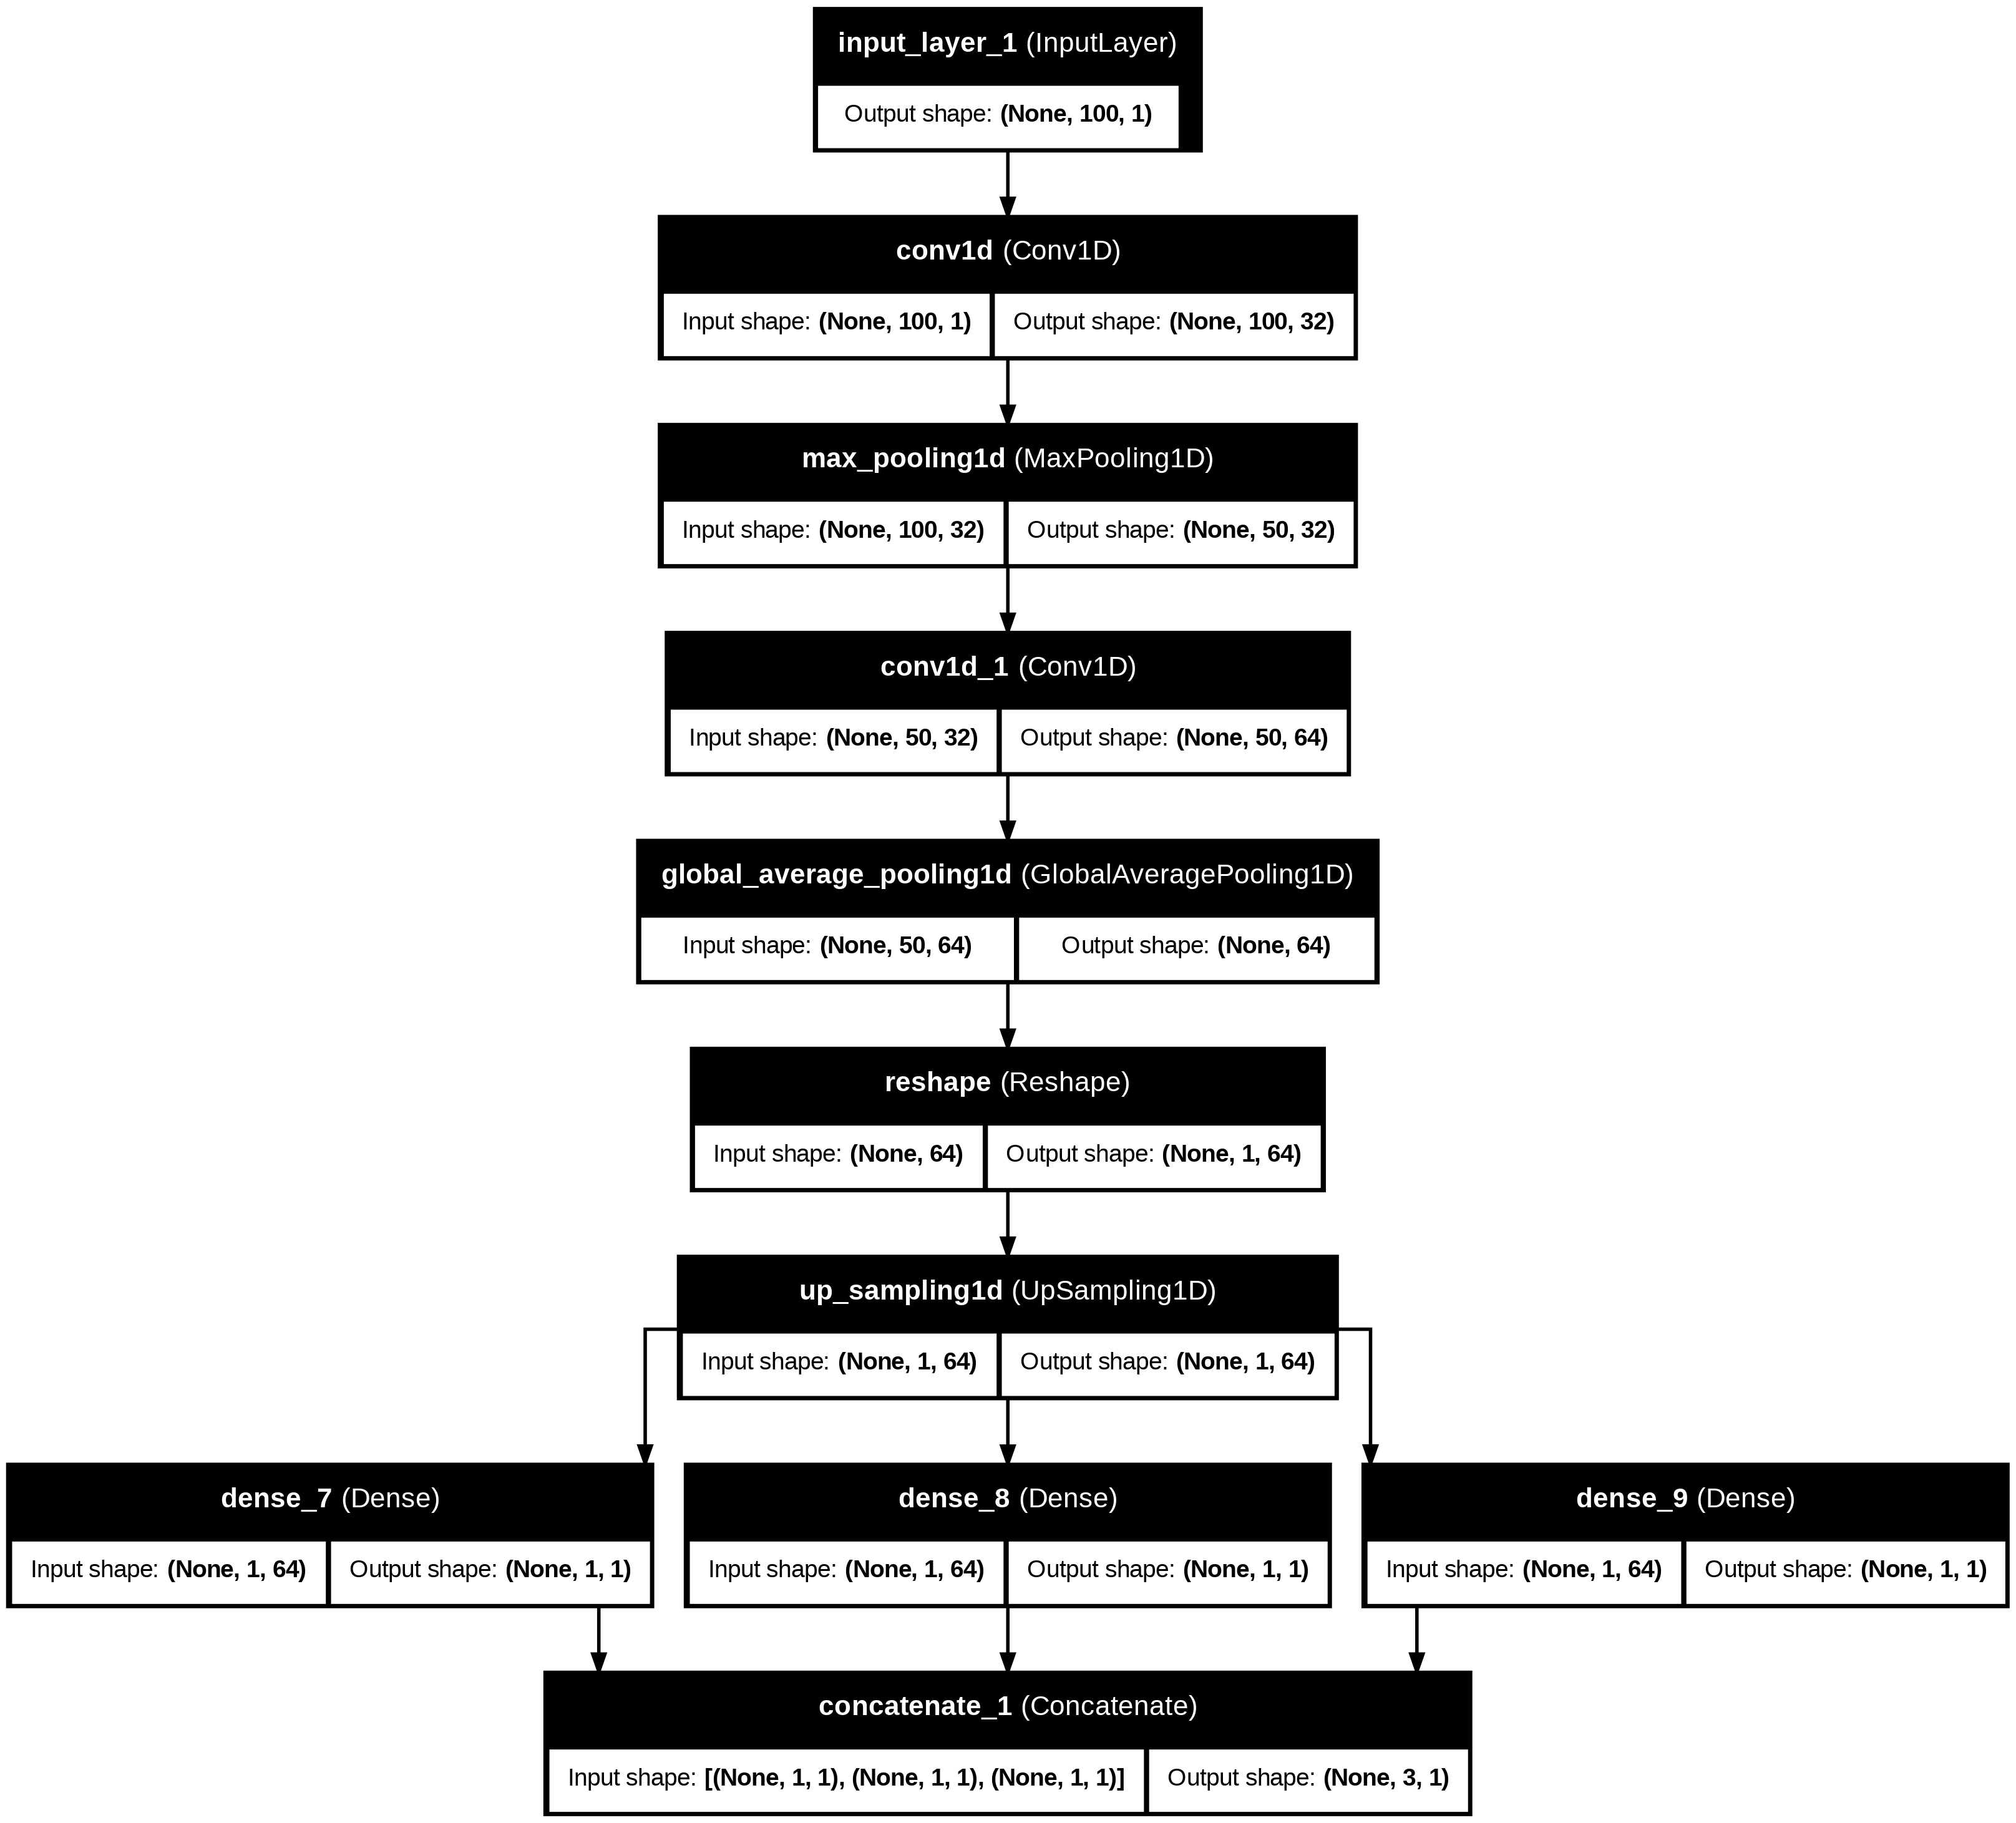

In [20]:
#@title Conv1D Autoencoder for likelihood-based anomaly detection
def build_conv1d_autoencoder(input_shape, filters=32, kernel_size=3):
  input = keras.Input(shape=input_shape, dtype="float32")  # (chunk_size, 1)

  # Encoder
  latent = layers.Conv1D(filters, kernel_size, activation="relu", padding="same")(input)
  latent = layers.MaxPooling1D(pool_size=2)(latent)
  latent = layers.Conv1D(filters * 2, kernel_size, activation="relu", padding="same")(latent)
  latent = layers.GlobalAveragePooling1D()(latent)  # (batch, latent_dim)

  # Decoder
  latent = layers.Reshape((1, latent.shape[1]))(latent)
  decoder = layers.UpSampling1D(size=1)(latent)

  # Predict distribution parameters
  mu = layers.Dense(1, activation="linear")(decoder)
  sigma = layers.Dense(1, activation="softplus")(decoder)
  alpha = layers.Dense(1, activation="linear")(decoder)

  output = layers.concatenate([mu, sigma, alpha], axis=1)
  ae = keras.Model(input, output)

  return ae

ae_conv = build_conv1d_autoencoder(input_shape=(chunk_size, 1)) # 3-D input
plot_model(ae_conv, to_file="conv_autoencoder_plot.png", show_shapes=True, show_layer_names=True)


In [21]:
ae_conv.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 32)   │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 50, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 64)     │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 1, 64)     │          0 │ reshape[0][0]     │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1, 1)      │         65 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1)      │         65 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 1)      │         65 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3, 1)      │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ dense_8[0][0],    │
│                     │                   │            │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,531 (25.51 KB)

 Trainable params: 6,531 (25.51 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

#### Dense AE

In [23]:
# Compiling
ae.compile(optimizer = "adam", loss = skew_normal_nll) # choose the custom loss
history = ae.fit(x = training_data, y = training_data,
                 validation_data = (val_data_perturbed, val_data_perturbed),
                 epochs = 50, batch_size = 16, callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.5278 - val_loss: 1.4515
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4293 - val_loss: 1.4430
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4225 - val_loss: 1.4404
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4192 - val_loss: 1.4387
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4175 - val_loss: 1.4375
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4168 - val_loss: 1.4392
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4162 - val_loss: 1.4381
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4155 - val_loss: 1.4363
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4142 - val_loss: 1.4365
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4146 - val_loss: 1.4364
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4131 - val_loss: 1.4359
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4122 - val_lo

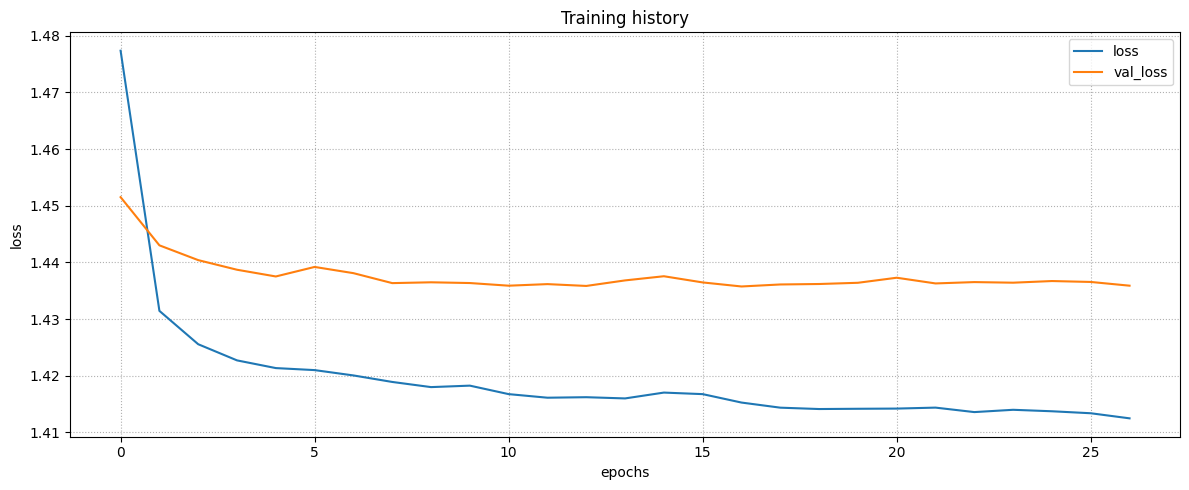

In [24]:
show_history(history)

#### 1D-conv AE

In [25]:
ae_conv.compile(optimizer = "adam", loss = skew_normal_nll)
history_conv = ae_conv.fit(x = training_data, y = training_data,
                 validation_data = (val_data_perturbed, val_data_perturbed),
                 epochs = 50, batch_size = 16, callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.4798 - val_loss: 1.4308
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4134 - val_loss: 1.4268
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4103 - val_loss: 1.4258
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4094 - val_loss: 1.4242
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4087 - val_loss: 1.4242
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4086 - val_loss: 1.4271
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4089 - val_loss: 1.4278
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4085 - val_loss: 1.4239
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4080 - val_loss: 1.4225
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4077 - val_loss: 1.4225
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4076 - val_loss: 1.4224
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4075 - val_

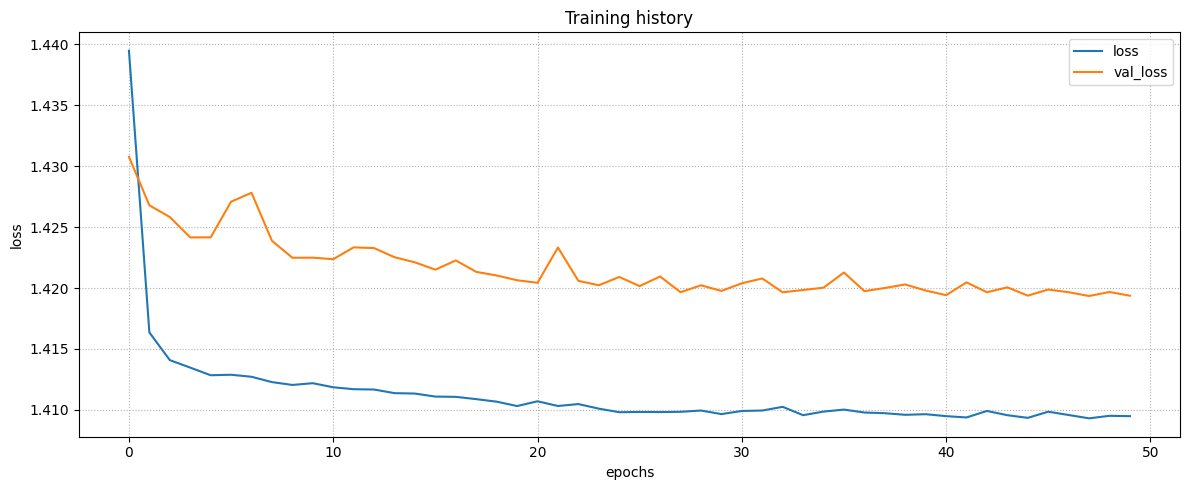

In [26]:
show_history(history_conv)

#### Training results

In [27]:
# Extract final training and validation losses
mean_train_ll_dense = history.history['loss'][-1]
mean_val_ll_dense = history.history['val_loss'][-1]
mean_train_ll_conv = history_conv.history['loss'][-1]
mean_val_ll_conv = history_conv.history['val_loss'][-1]

# Print training and validation losses
print(f"Training Loss     | Dense: {mean_train_ll_dense:.4f} | Conv: {mean_train_ll_conv:.4f}")
print(f"Validation Loss   | Dense: {mean_val_ll_dense:.4f} | Conv: {mean_val_ll_conv:.4f}")

Training Loss     | Dense: 1.4125 | Conv: 1.4095
Validation Loss   | Dense: 1.4359 | Conv: 1.4194


In [28]:
# Initialize a list to store the likelihoods of all training samples
train_likelihoods = []

# Loop through all training samples
for chunk in range(num_chunks):
    # Select the training sample
    test_sample = training_data[chunk]
    test_sample = np.expand_dims(test_sample, axis=0)

    # Predict the output using the trained model
    ae_output = ae_conv.predict(test_sample, verbose=0)

    # Compute the likelihood for this sample using your skew_normal_nll function
    test_likelihood = skew_normal_nll(test_sample, ae_output)

    # Append the likelihood to the list
    train_likelihoods.append(test_likelihood)

# Convert the list to a numpy array for easier computation
train_likelihoods = np.array(train_likelihoods)

# Compute the standard deviation of the training likelihoods
stdev_train_ll = np.std(train_likelihoods)

# Print the standard deviation
print(f"Standard deviation of training likelihoods: {stdev_train_ll}")

Standard deviation of training likelihoods: 0.07314541935920715


#### Compute the fixed threshold, up to the 99.8th percentile, to determine anomalies

In [29]:
threshold_perc = np.percentile(train_likelihoods, 99.8)
print(f"99.8th Threshold: {threshold_perc:.4f}")

99.8th Threshold: 1.6060


### **Evaluation**

In [30]:
# Models
models= [ae, ae_conv]
ae.name = "ae_dense"
ae_conv.name = "ae_conv"

In [31]:
# Generate test data
test_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples)
test_data, _ = reshape_data(test_data, chunk_size)

In this section, we will evaluate our model using different versions of the same perturbed test set, each with varying burst strengths. The goal is to find the optimal balance between:

* The **distinctiveness** of the background signal and the anomalous signals, ensuring that the test likelihood is sufficiently higher than the baseline, clearly reflecting the distinction between normal and anomalous signals.

* The **burst strength**, generating anomalies that are detectable but not overly obvious, preventing the anomalies from standing out too clearly.

In [32]:
def compute_likelihood(data, ae, num_chunks):
  likelihoods = []
  for chunk in range(num_chunks):
    sample = data[chunk]
    sample = np.expand_dims(sample, axis=0)
    ae_output = ae.predict(sample, verbose=0)
    likelihood = skew_normal_nll(sample, ae_output)
    likelihoods.append(likelihood)
  return likelihoods

Defining the dict for storing the results of the evaluation

In [33]:
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, classification_report,
    confusion_matrix, precision_score, recall_score
)

# Setting perturbation levels
burst_strengths = {
    "Weak": {"lb": 25,  "ub": 40},
    "Medium": {"lb": 40, "ub": 60},
    "Strong": {"lb": 60, "ub": 80},
    "Very strong": {"lb": 80, "ub": 100}
}

# Results dict.
results = {model.name: {label: {
    "Avg_ll": None, "Std dev": None, "AUC": None,
    "Precision": None, "Recall": None, "F1": None,
    "Best Threshold (F1)": None
} for label in burst_strengths.keys()}
           for model in models}

Let's evaluate and plot the performances of the model for each of the validation set version, for each of the chosen metrics:


*   ROC curve
*   AUC
*   Precision-Recall curve
*   F1-score



Evaluating model: ae_dense


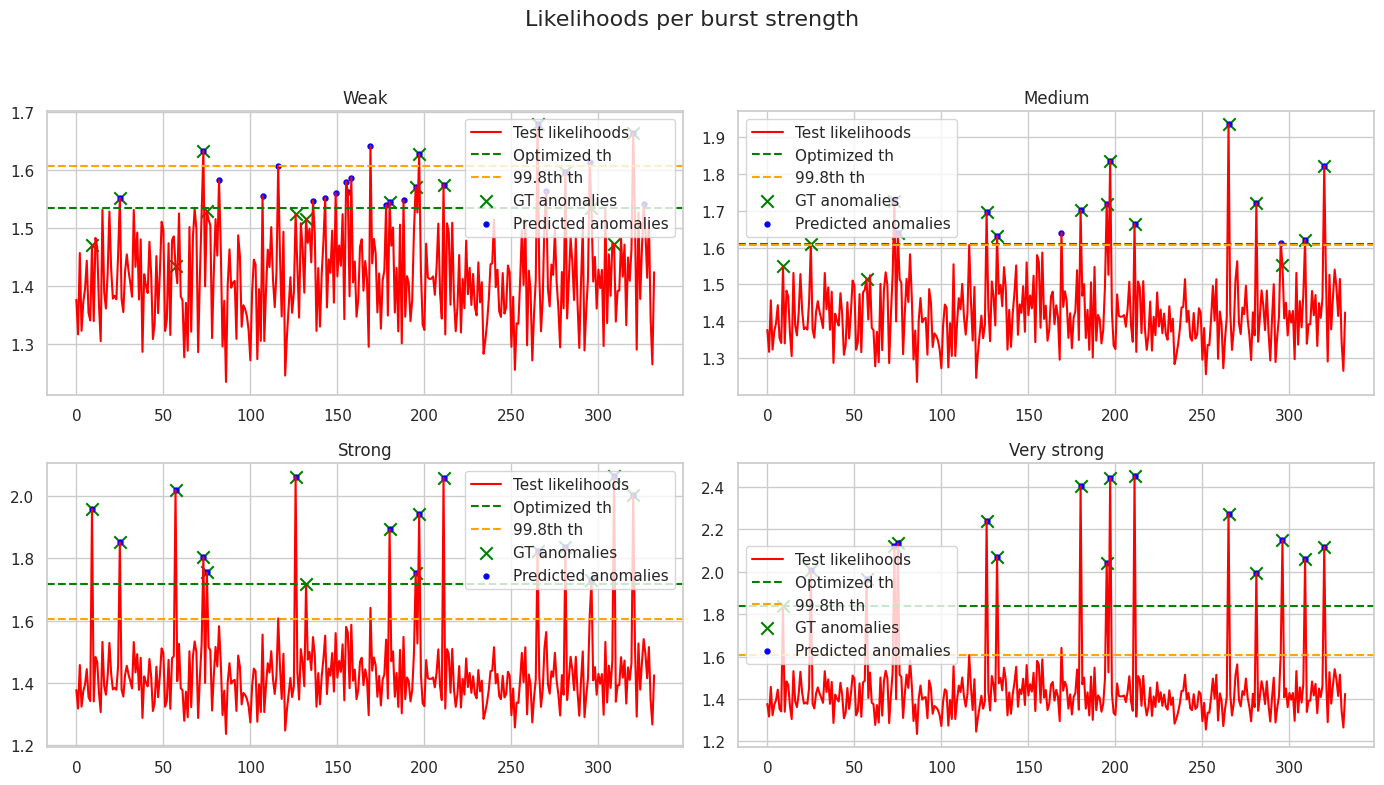

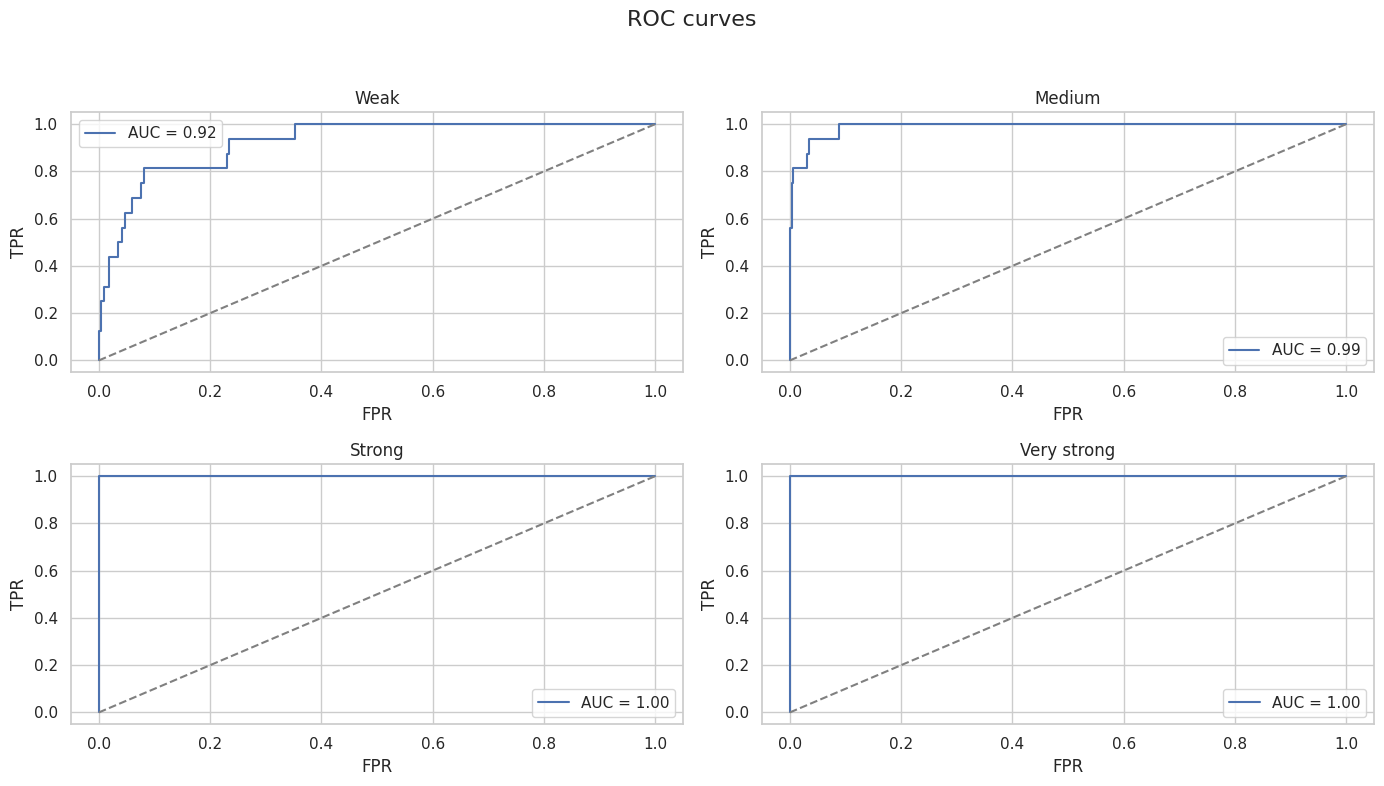

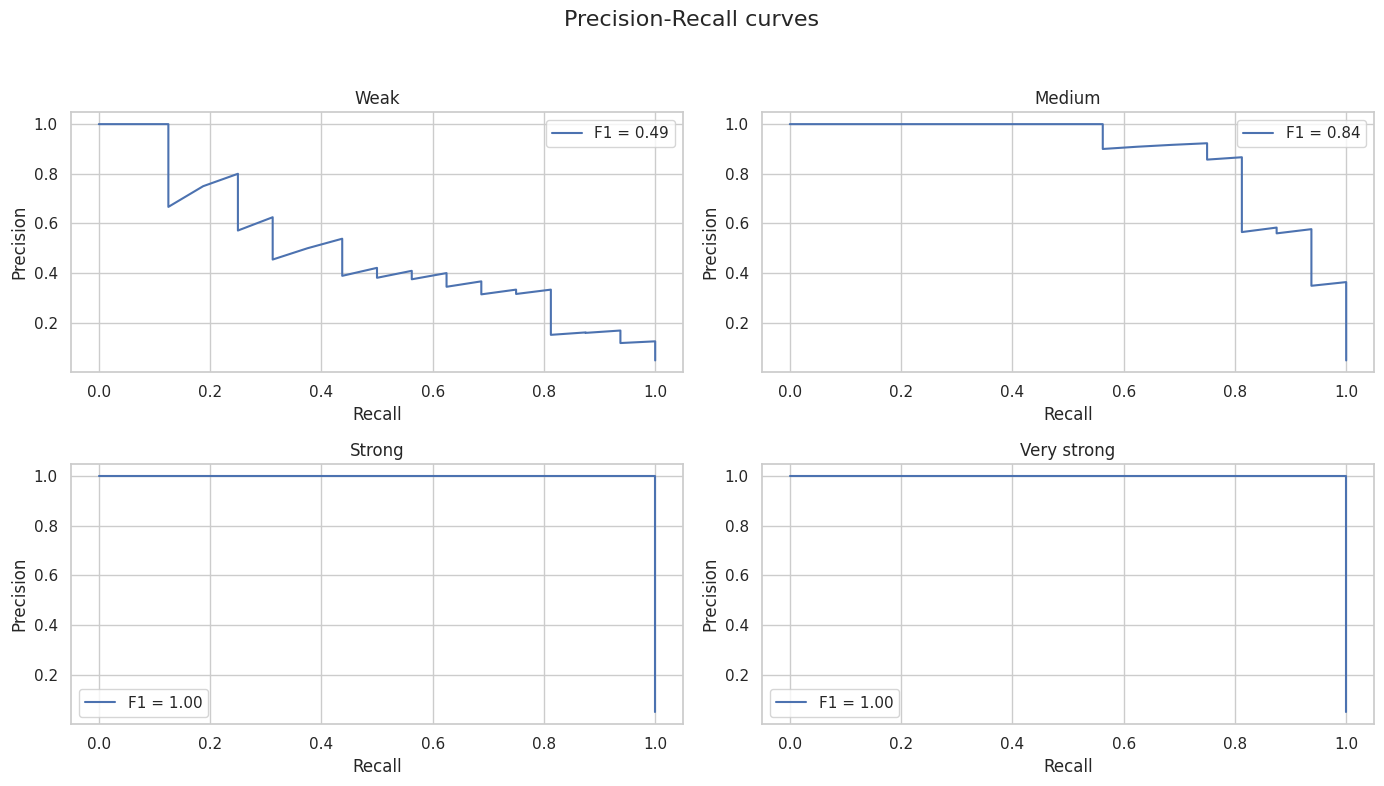

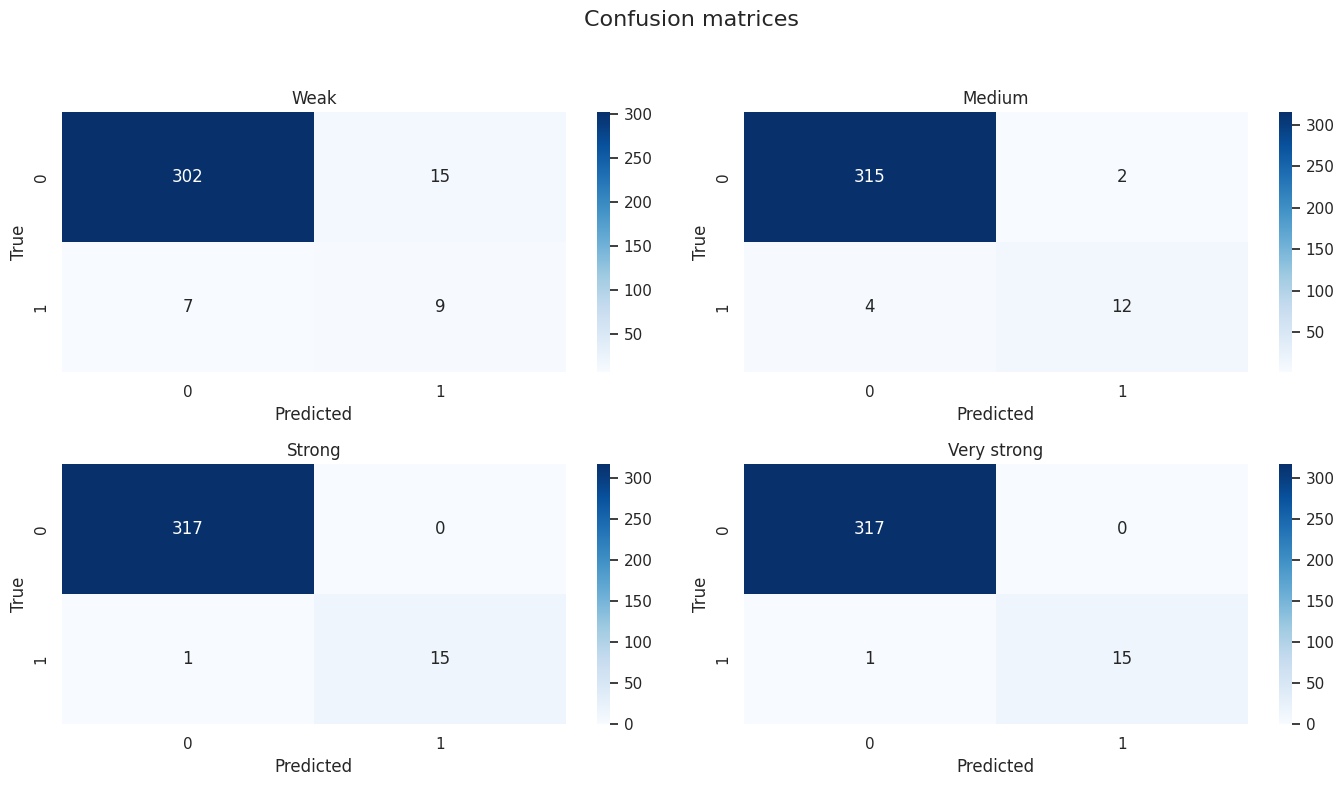

Evaluating model: ae_conv


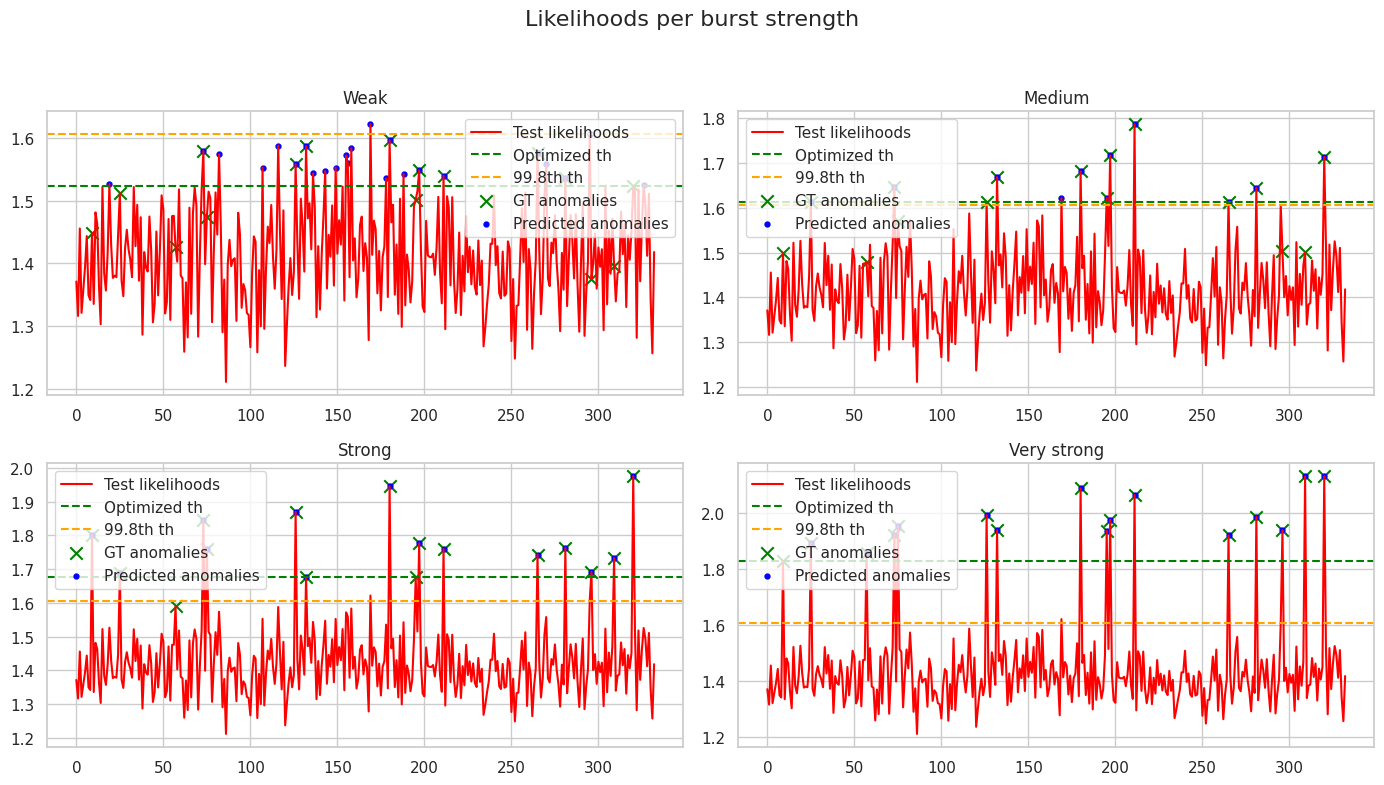

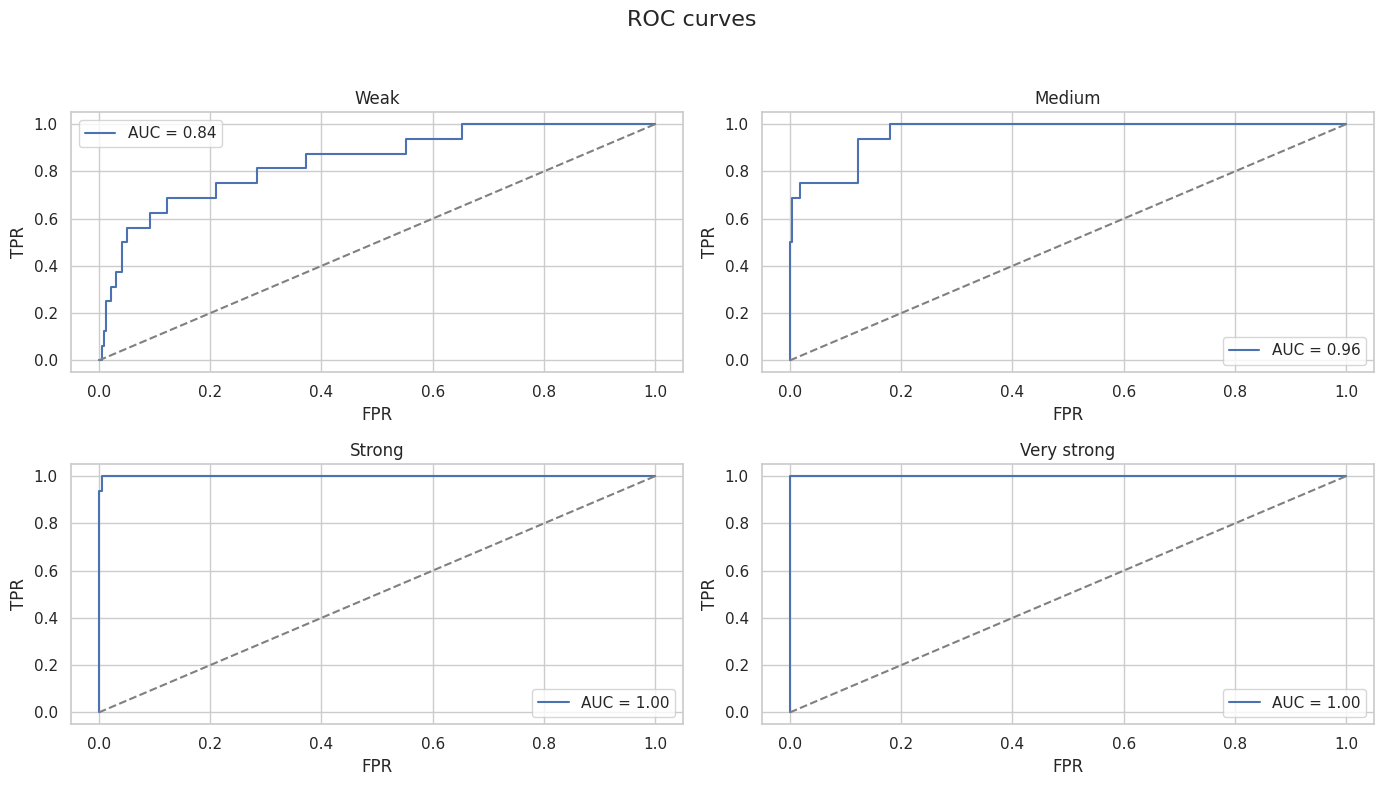

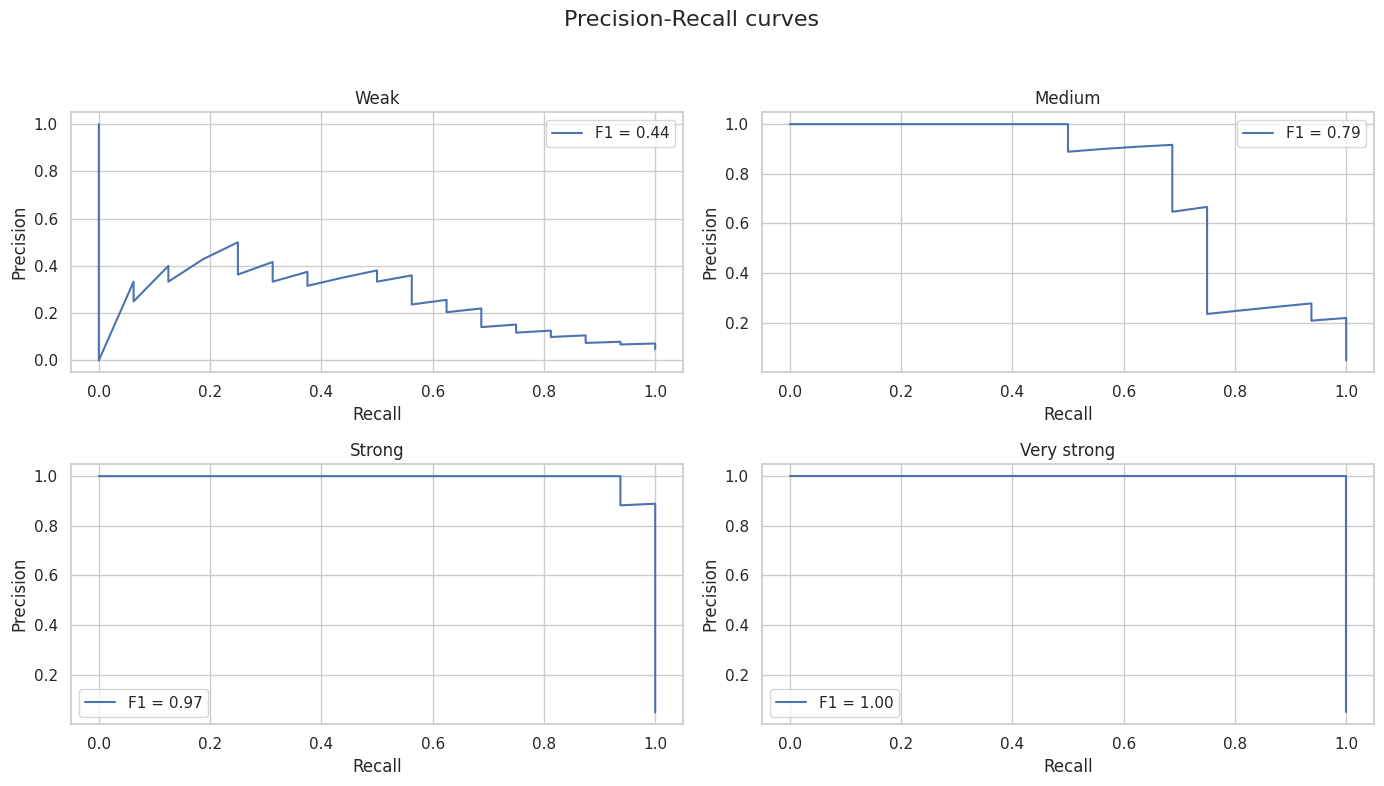

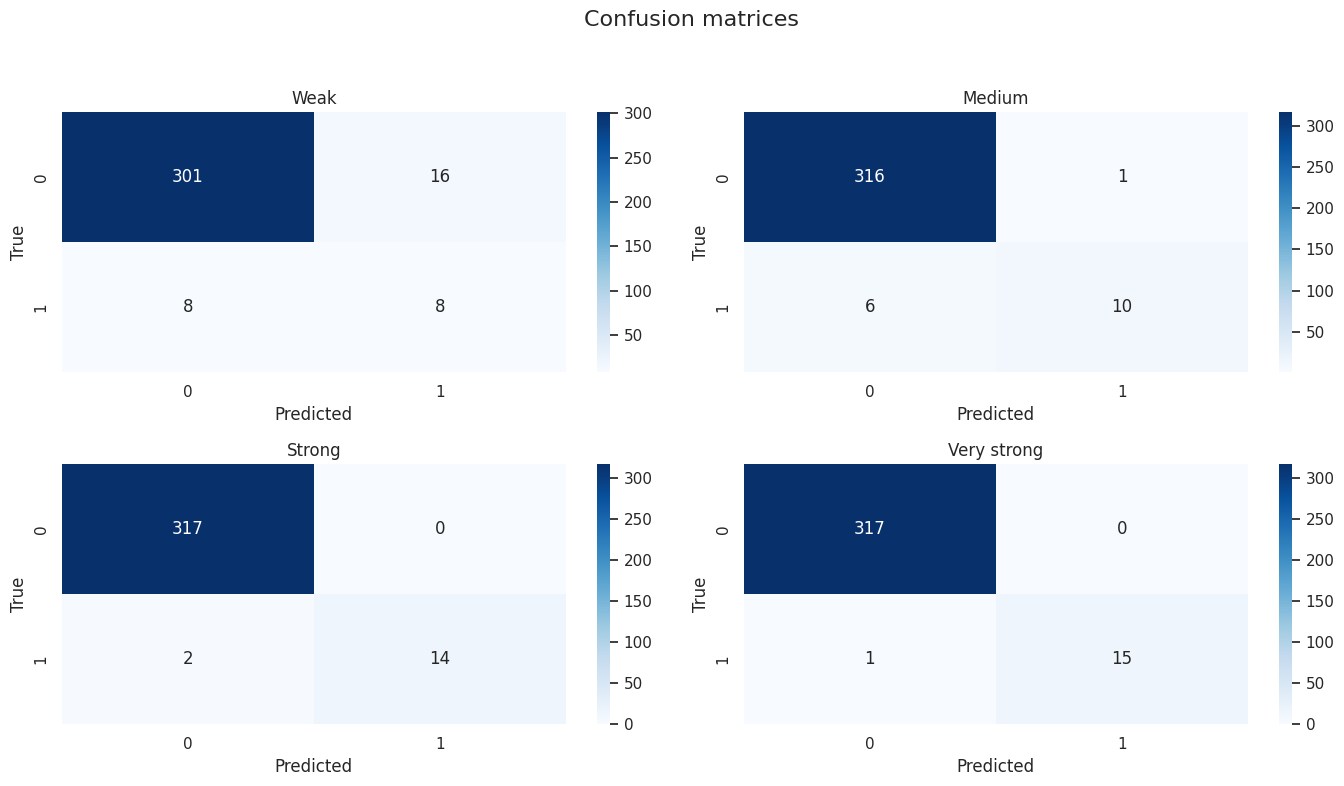

In [34]:
# Evaluating and plotting
for model in models:
  print(f"Evaluating model: {model.name}")
  evaluate_and_plot_per_strength(test_data, results, model,
                                 fixed_anomalies_idx, test_anomaly_perc,
                                 burst_strengths, scaler, compute_likelihood,
                                 model, train_likelihoods, num_chunks_eval, threshold_perc,
                                 peak_time, burst_duration
  )

As we can see, using the 1D-convolutional architecture makes the difference between strong and very strong signals more apparent compared to the dense architecture.

This is likely because the Conv1D model is better at leveraging the **temporal structure** of the bursts and capturing fine-grained differences in intensity, whereas the dense model may be more prone to overlooking these subtleties or averaging them out.

In [35]:
# Showing results
for model in models:
  print(f"Model: {model.name}")
  df_results = pd.DataFrame(results[model.name]).T
  print(df_results.round(4))
  print("------------------------------------------------------------------")

Model: ae_dense
             Avg_ll  Std dev     AUC  Precision  Recall      F1  \
Weak            NaN   0.0804  0.9243     0.3750  0.5625  0.4878   
Medium          NaN   0.0961  0.9894     0.8571  0.7500  0.8387   
Strong          NaN   0.1286  1.0000     1.0000  0.9375  1.0000   
Very strong     NaN   0.1766  1.0000     1.0000  0.9375  1.0000   

             Best Threshold (F1)  Avg ll  
Weak                      1.5348  1.4189  
Medium                    1.6106  1.4250  
Strong                    1.7162  1.4350  
Very strong               1.8366  1.4471  
------------------------------------------------------------------
Model: ae_conv
             Avg_ll  Std dev     AUC  Precision  Recall      F1  \
Weak            NaN   0.0775  0.8429     0.3333  0.5000  0.4390   
Medium          NaN   0.0876  0.9639     0.9091  0.6250  0.7857   
Strong          NaN   0.1084  0.9996     1.0000  0.8750  0.9677   
Very strong     NaN   0.1426  1.0000     1.0000  0.9375  1.0000   

             Be

**Which is the best model?**

We notice that the Conv1D may model the **distribution more precisely**, since it has a lower average likelihood, which is clearly a good sign. Moreover, it has also a lower standard deviation, which means that it is more certain in its estimate of the background signal distribution.

On the other hand, it **underperforms** on classification metrics! This may suggest it underestimates subtle anomalies or fails to clearly separate borderline cases (especially for *weak* signals).


#### **Final evaluation**: choose a burst strength level

For the final evaluation, we will use the 1D-Conv model and we will adopt a **medium**-strength perturbation level as our test condition. This level offers a **trade-off** between anomaly detectability and realism, allowing us to assess performance under the previous conditions.

This new test set will act as a *real test* set, an unseen one.

In [36]:
# Choose perturbation level
strength_lvl = "Medium"

# Choose model
model = ae

# Choose the anomaly percentage
final_test_anomaly_perc = 0.02

Let's proceed with the actual evaluation:

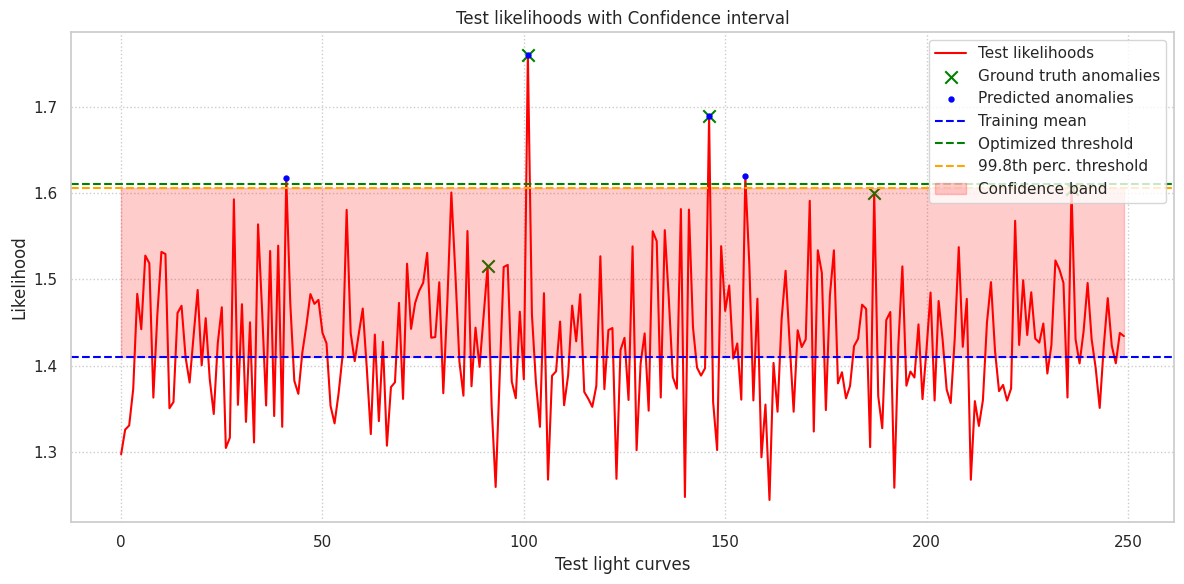


== Classification Report (F1 Threshold) ==
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       245
         1.0       0.50      0.40      0.44         5

    accuracy                           0.98       250
   macro avg       0.74      0.70      0.72       250
weighted avg       0.98      0.98      0.98       250

== Classification Report (99.8th Percentile) ==
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       245
         1.0       0.50      0.40      0.44         5

    accuracy                           0.98       250
   macro avg       0.74      0.70      0.72       250
weighted avg       0.98      0.98      0.98       250



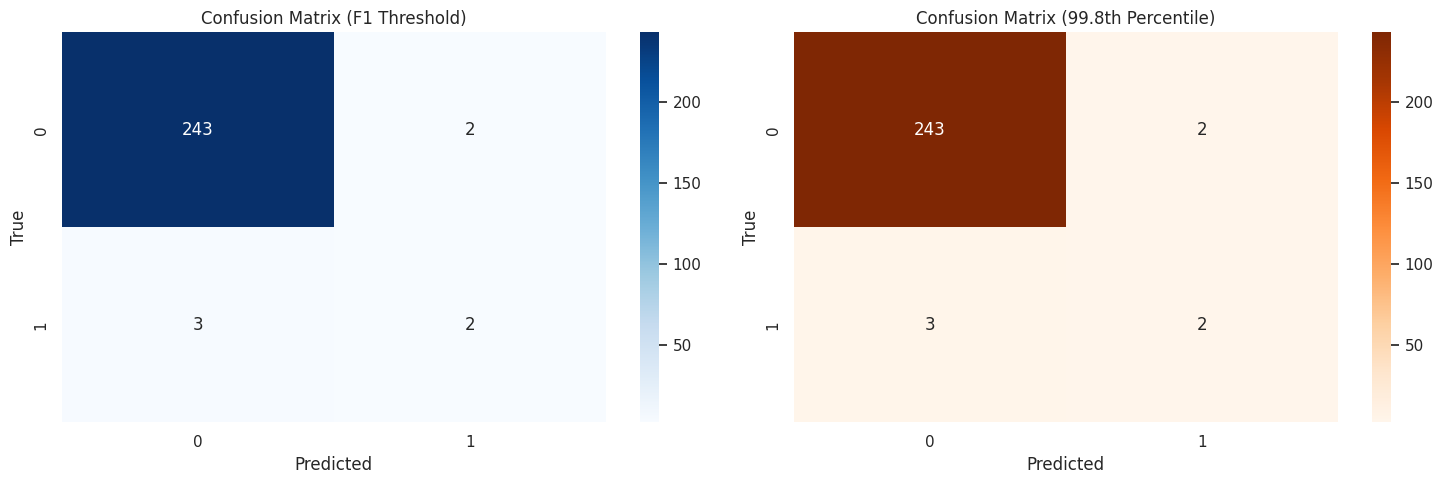

In [37]:
# Generate a new test set
test_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples//4)
test_data, _ = reshape_data(test_data, chunk_size)

# Update num_chunks_eval based on the new test data shape
num_chunks_eval = test_data.shape[0]

# Recalculate fixed_anomalies_idx using the updated num_chunks_eval
fixed_anomalies_idx = np.random.choice(
    num_chunks_eval, size=int(final_test_anomaly_perc * num_chunks_eval),
    replace=False
)

# Perturbing
amplitudes = burst_strengths[strength_lvl]
test_data_perturbed, test_anomaly_indices = add_burst(
    test_data, fixed_anomalies_idx, final_test_anomaly_perc, amplitudes,
    peak_time, burst_duration
)
test_data_perturbed = scaler.transform(test_data_perturbed)

# Likelihoods
likelihoods = compute_likelihood(test_data_perturbed, model, num_chunks_eval)
avg_ll, std_ll = np.mean(likelihoods), np.std(likelihoods)

# Ground truth and scores
y_true = np.zeros(num_chunks_eval)
y_true[test_anomaly_indices] = 1
y_scores = np.array(likelihoods)

# Precision-Recall & F1
precision, recall, pr_thresh = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Retrieving best threshold for the selected perturbation lvl
best_threshold = results[model.name][strength_lvl]["Best Threshold (F1)"]

# Predictions
y_pred_f1 = (y_scores > best_threshold).astype(int)
y_pred_perc = (y_scores > threshold_perc).astype(int)

# Confusion matrices
cm_f1 = confusion_matrix(y_true, y_pred_f1)
cm_perc = confusion_matrix(y_true, y_pred_perc)

# Print anomalous indices
anomalous_indices_f1 = np.where(y_scores > best_threshold)[0]
anomalous_indices_perc = np.where(y_scores > threshold_perc)[0]

# Plot likelihoods
plot_lls_anomalies(likelihoods, mean_train_ll_conv, test_anomaly_indices,
                   anomalous_indices_f1, best_threshold, threshold_perc)

# Print classification reports
print("\n== Classification Report (F1 Threshold) ==")
print(classification_report(y_true, y_pred_f1))
print("== Classification Report (99.8th Percentile) ==")
print(classification_report(y_true, y_pred_perc))

# Confusion matrices
plot_conf_matrices(cm_f1, cm_perc)

#### ROC curve

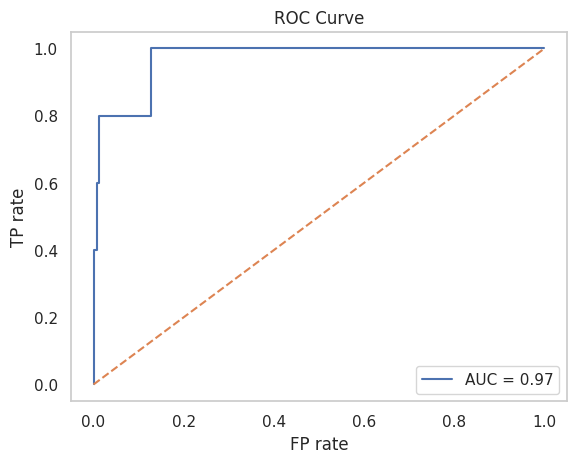

In [38]:
plot_ROC(y_true, y_scores)

#### PR curve

Best threshold (based on F1-score): 1.6003
Best F1-score: 0.6667


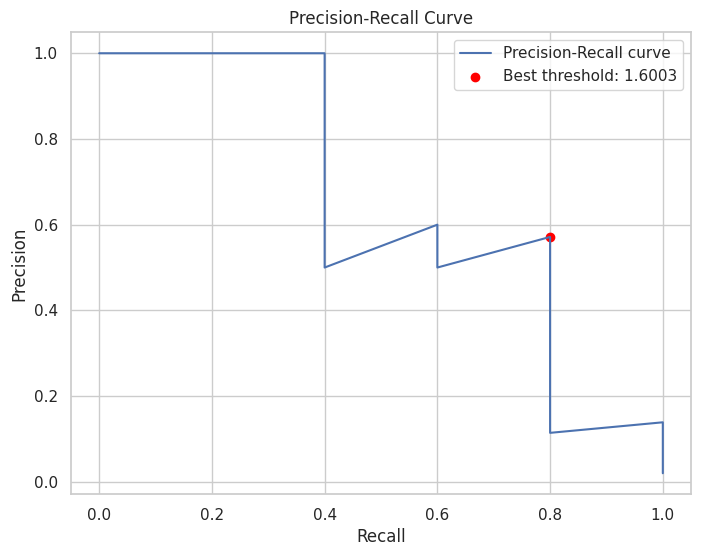

In [39]:
plot_PR_curve(y_true, y_scores)

## Considerations

What I've noticed is that the evaluation process is more robust using 100'000 samples instead of just 10'000. This is quite obvious because with more samples the model learns more accurately the statistical properties (mean, variance, skewness) of the underlying distribution (of the background signal). Namely, we generalize better.

**TODO**

*   try other total training **samples** values (tried 10'000 and 100'000)
*   try other chunk **sizes** (now 100)
*   try to **diversify** the perturbation (now always starting at bin n°10 and lasting 20 bins)
  - random perturbations, for example
